In [1]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering
using Distances  # Este es necesario para hacer la matriz de distancia, es complemento a Clustering.

In [2]:
push!(LOAD_PATH, "../Preprocesamiento/")
push!(LOAD_PATH, ".")
using ArraySetTools # pa aprovechar las cosas que ya tenemos.
using Aglomerar

In [3]:
using LsqFit

In [4]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [5]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

fruncio=Array{Float64}(undef, 0,4)

for k in keys(DatosCMP)
    dat=DatosCMP[k]
    (alto, ancho)=size(dat)
    auxt=ones(alto).*k
    afafa=hcat(dat, auxt)
    fruncio=vcat(fruncio,afafa)
end

fruncio=fruncio[sortperm(fruncio[:, 4]), :];

In [6]:
masamax=maximum(fruncio[:,3])

12329.550282478333

In [7]:
nmax=maximum(fruncio[:,4])

2000.0

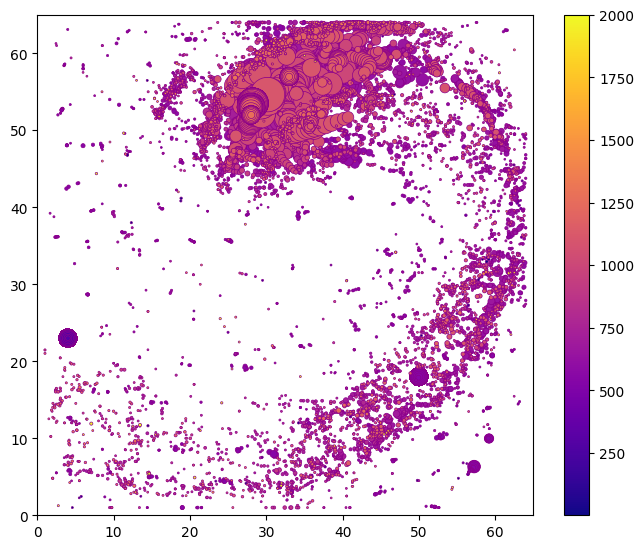

In [8]:
fig=plot4Ddiscs(fruncio)


In [9]:
histogordis=fit(Histogram, fruncio[:,3], 1:20:5001)

Histogram{Int64,1,Tuple{StepRange{Int64,Int64}}}
edges:
  1:20:5001
weights: [0, 386, 2840, 1481, 885, 491, 324, 242, 178, 162  …  1, 3, 3, 1, 3, 3, 1, 1, 3, 0]
closed: left
isdensity: false

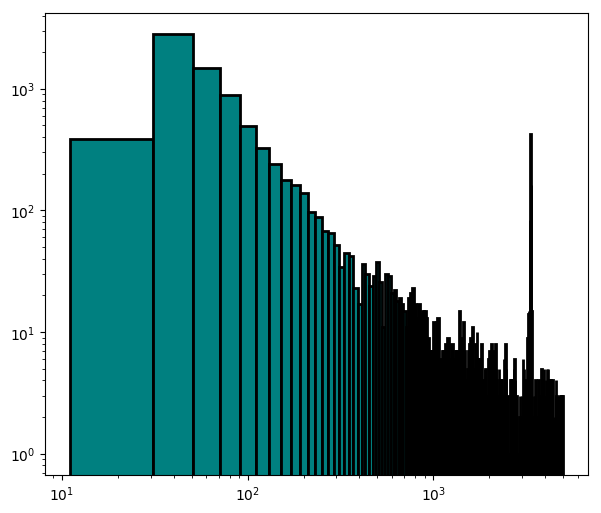

In [10]:
#histogordis.weights
figure(figsize=(7,6))
bar(histogordis.edges[1][1:end-1], histogordis.weights, width=20, 
    color="teal", edgecolor="k", linewidth=2)
yscale("log")
xscale("log")
show()

In [11]:
gmin=nquantile(fruncio[:,3], 10)[2]

44.147528648376465

In [12]:
frunciofiltrado=fruncio[fruncio[:,3].>gmin,:]
size(frunciofiltrado)

(8856, 4)

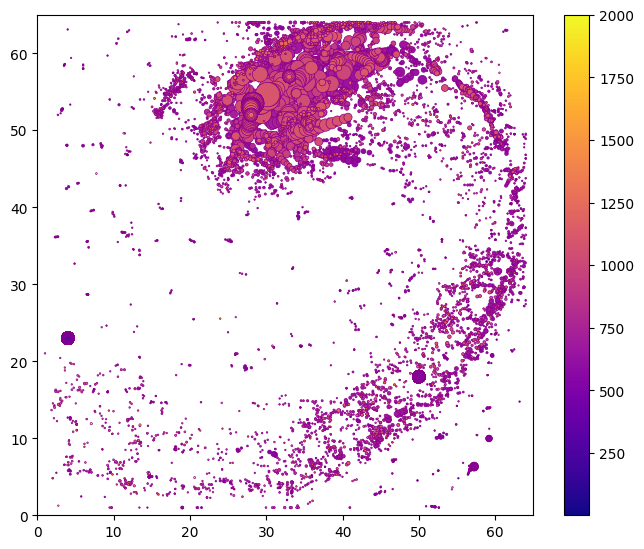

In [13]:
plot4Ddiscs(frunciofiltrado, escala=0.025)


In [14]:
# clust1=fruncio[:,1:2];
clust1=permutedims(frunciofiltrado)

4×8856 Array{Float64,2}:
 46.7927  27.3672   30.7173  55.1767   …    24.1639    11.3209     2.75101
 54.6672   4.15315  56.2334   4.80699       14.6006    49.6291     1.24794
 45.3749  63.8133   46.5284  47.0146        56.2697    64.1216    45.5731 
  1.0      1.0       1.0      1.0         2000.0     2000.0     2000.0    

In [15]:
clust1[3,:]=normalizar1(clust1[3,:]).*64
clust1[4,:]=normalizar1(clust1[4,:]).*64;

In [16]:
clustspaciotiempo=vcat(clust1[1:2,:], transpose(clust1[4,:]))

3×8856 Array{Float64,2}:
 46.7927  27.3672   30.7173  55.1767   …  60.5552  24.1639  11.3209   2.75101
 54.6672   4.15315  56.2334   4.80699     57.4671  14.6006  49.6291   1.24794
  0.032    0.032     0.032    0.032       64.0     64.0     64.0     64.0    

In [17]:
function scatterclust(puntos, clustn)

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(puntos[:,1],puntos[:,2], s=0.5, c=clustn, cmap="inferno")
colorbar(fraction=0.045)
end

scatterclust (generic function with 1 method)

In [18]:
# decisiones, decisiones
dd4d=pairwise(Euclidean(), clust1, dims=2);
dd3d=pairwise(Euclidean(), clustspaciotiempo, dims=2);
dd2d=pairwise(Euclidean(), clust1[1:2,:], dims=2);

# Aquí abajo esta DBSCAN


In [19]:
db3d=dbscan(dd3d, 2, 6)

DbscanResult([7, 18, 361, 435, 447, 472, 539, 591, 640, 657  …  7597, 7659, 7847, 7915, 8290, 8346, 8362, 8632, 8676, 8740], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [295, 7, 288, 16, 6, 13, 9, 6, 6, 9  …  7, 28, 7, 6, 8, 27, 6, 9, 7, 7])

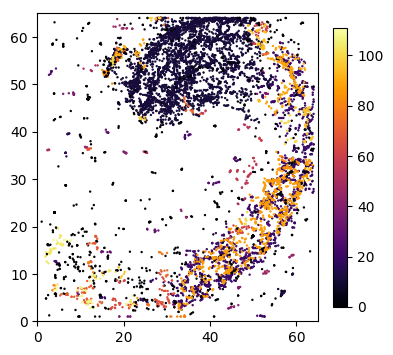

PyObject <matplotlib.colorbar.Colorbar object at 0x7f70afc07588>

In [20]:
scatterclust(frunciofiltrado, db3d.assignments)

In [21]:
aver=count(x->x==0, db3d.assignments)

976

In [22]:
aver=count(x->x==0, db3d.assignments)

976

In [23]:
length(0:112)

113

In [24]:
function historango(asignamientos)
    la=length(unique(asignamientos))
    tamgroups=fit(Histogram, asignamientos, 0:la, closed=:left)
    ordenado=sortperm(tamgroups.weights, rev=true)
    return (tamgroups, ordenado)
end

historango (generic function with 1 method)

In [25]:
residuo(unos, otros)=sum((unos.-otros).^2)

function rsquared(reales, modelos)
    sstot=sum((reales.-mean(reales)).^2)
    ssreg=sum((modelos.-mean(reales)).^2)
    ssres=sum((reales.-modelos).^2)
    res=1-ssres/sstot
    otrores=ssreg/sstot
    return ( res, otrores)
end
    

rsquared (generic function with 1 method)

In [26]:
# por alguna razon me da buena espina ajustar en espacio log
@. linmodel(x,p)=p[2]*x+p[1]



function dbscanfit(datosdist; radio=1.0, tantos=4)
    db=dbscan(datosdist, radio, tantos)
    sinasignar=count(x->x==0, db.assignments)
    ngrups=length(unique(db.assignments))
    
    (histo, orden)=historango(db.assignments)
    xdata=histo.edges[1][1:end-1];
    ydata=histo.weights[orden];

    elgrande=ydata[1]
    
    xdatalin=log.(xdata.+1)
    ydatalin=log.(ydata);
    p0=Float64[7, -1.5]
    lwlin=Float64[5, -4]
    uplin=Float64[15, 0]
    
    fitlin=curve_fit(linmodel, xdatalin, ydatalin, p0, lower=lwlin, upper=uplin)
    
    fauxlin(x)=linmodel(x, fitlin.param)
    
    yysmlin=fauxlin.(xdatalin);
    
    (rr1, rr2)=rsquared(ydatalin, yysmlin)
    
    return (rr1, rr2 ,fitlin, sinasignar, elgrande, ngrups)
    
end

dbscanfit (generic function with 1 method)

In [27]:
(rr1, rr2, modelo, nfeos, elgr,  ngrups)=dbscanfit(dd3d, radio=2, tantos=3)


(0.927946355183599, 0.9279463551845419, LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([6.21212, -0.976129], [-2.37366, -1.03396, -0.805684, -0.828053, -1.02186, -0.58672, 0.400642, 0.290501, 0.260687, 0.326918  …  -0.15579, -0.160197, -0.164584, -0.168951, -0.173299, -0.177628, -0.181938, -0.186228, -0.1905, -0.194754], [1.0 0.0; 1.0 0.693147; … ; 1.0 5.43372; 1.0 5.43808], true, Float64[]), 382, 5355, 230)

In [28]:
radii=(1, 1.5, 2, 2.5, 3)
nns=(2, 3, 4, 5, 6)
for r in radii, n in nns
    (rr1, rr2, modelo, nfeos, elgr,  ngrups)=dbscanfit(dd3d, radio=r, tantos=n);
    rprint=round(rr1, digits=3)
    println(" r=$r\t n=$n\t rq = $rprint\t nfeos=$nfeos\t elgr=$elgr\t ng= $ngrups ")
end

 r=1	 n=2	 rq = 0.978	 nfeos=606	 elgr=606	 ng= 1285 
 r=1	 n=3	 rq = 0.984	 nfeos=1346	 elgr=1346	 ng= 915 
 r=1	 n=4	 rq = 0.974	 nfeos=2300	 elgr=2300	 ng= 658 
 r=1	 n=5	 rq = 0.951	 nfeos=3193	 elgr=3193	 ng= 493 
 r=1	 n=6	 rq = 0.918	 nfeos=4023	 elgr=4023	 ng= 375 
 r=1.5	 n=2	 rq = 0.987	 nfeos=276	 elgr=1007	 ng= 691 
 r=1.5	 n=3	 rq = 0.987	 nfeos=660	 elgr=1007	 ng= 499 
 r=1.5	 n=4	 rq = 0.985	 nfeos=1060	 elgr=1060	 ng= 391 
 r=1.5	 n=5	 rq = 0.986	 nfeos=1523	 elgr=1523	 ng= 315 
 r=1.5	 n=6	 rq = 0.99	 nfeos=2040	 elgr=2040	 ng= 258 
 r=2	 n=2	 rq = 0.95	 nfeos=156	 elgr=5355	 ng= 343 
 r=2	 n=3	 rq = 0.928	 nfeos=382	 elgr=5355	 ng= 230 
 r=2	 n=4	 rq = 0.912	 nfeos=566	 elgr=5349	 ng= 174 
 r=2	 n=5	 rq = 0.906	 nfeos=777	 elgr=5308	 ng= 132 
 r=2	 n=6	 rq = 0.915	 nfeos=976	 elgr=3734	 ng= 112 
 r=2.5	 n=2	 rq = 0.911	 nfeos=113	 elgr=6144	 ng= 225 
 r=2.5	 n=3	 rq = 0.875	 nfeos=243	 elgr=6144	 ng= 160 
 r=2.5	 n=4	 rq = 0.849	 nfeos=349	 elgr=6142	 ng= 127 
 r=2.5	

In [29]:
    db=dbscan(dd3d, 1.5, 5)
    
    (histo, orden)=historango(db.assignments)
    xdata=histo.edges[1][1:end-1];
    ydata=histo.weights[orden];
   
    
    xdatalin=log.(xdata.+1)
    ydatalin=log.(ydata);
    p0=Float64[7, -1.5]
    lwlin=Float64[5, -4]
    uplin=Float64[15, 0]
    
    fitlin=curve_fit(linmodel, xdatalin, ydatalin, p0, lower=lwlin, upper=uplin)
    
    fauxlin(x)=linmodel(x, fitlin.param)
    
    yysmlin=fauxlin.(xdatalin);
    
  

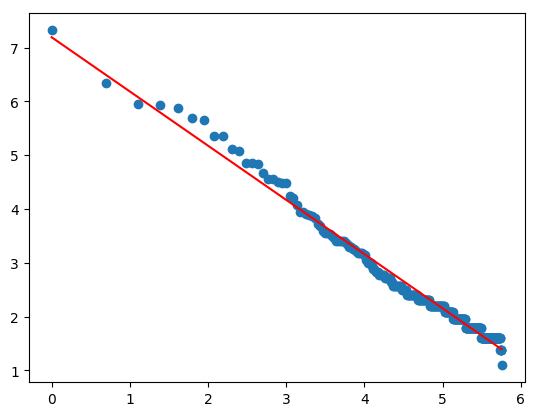

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f70afbeb400>

In [30]:
scatter(xdatalin, ydatalin, marker="o")
plot(xdatalin, fauxlin.(xdatalin), color="red")


# Markov Cluster

Aqui vamos a probar el Markov Clustering

In [101]:
f(x)= x !=0 ? x : 0 

f (generic function with 1 method)

In [103]:
pesos=f.(dd3d);

In [ ]:
mark=mcl(pesos, maxiter=10)

# Aqui abajo esta el Jerarquico.

In [ ]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

In [ ]:
hcorta=0.333 #estrictamente mas
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [ ]:
size(unique(clust4d))

In [ ]:
scatterclust(frunciofiltrado, clust4d)
scatterclust(frunciofiltrado, clust3d)
scatterclust(frunciofiltrado,clust2d)

In [ ]:
temp=hcat(frunciofiltrado, db2d.assignments)
dict2d=declustaset(temp, enteros=false)
blabla2d=filtraclusterchicos(dict2d, 20);

In [ ]:
length(keys(blabla2d))

In [ ]:

for k in keys(blabla2d)
    l=length(blabla2d[k])
    println(" el grupo $k tiene $l elementos para regiones de Sources")
 end



In [ ]:
  punchis=[0 0 0 0]
for k in (0,)
    punchis=[0 0 0 0]
    for h in dict2d[k]
        punchis=vcat(punchis, h)
    end
end

In [ ]:

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(punchis[:,1],punchis[:,2], s=0.5,c=punchis[:,4], cmap="inferno")
colorbar(fraction=0.045)

In [ ]:
blatabla3d=dictatabla(blabla2d);
#buf=dictatabla(blabla3d, una=false)

In [ ]:
fafa=figure(figsize=(5,4))

#ax=gca()
#ax.set_facecolor("k")
axis("equal")

xlim(-5.0,65.0)
ylim(0.0,65.0)
scatter(blatabla3d[:,1], blatabla3d[:,2], c=blatabla3d[:,5], s=0.5, cmap="inferno")
scatter((-1).*blatabla3d[:,1].+62, blatabla3d[:,2], c=blatabla3d[:,5], s=0.5, cmap="inferno")

show()
#colorbar()

In [ ]:
unique(blatabla[:,3])

In [ ]:
using QHull

In [ ]:
convexas=Dict{Any, Any}()
for k in keys(buf)
    puf =buf[k]
    print(k, " ")
    ch = chull(puf)
    convexas[k]=ch
end

In [ ]:
poly=PyPlot.matplotlib.patches.Polygon
appnplot=PyPlot.matplotlib.patches
colect=matplotlib.collections.PatchCollection

In [ ]:
keys(colect)

In [ ]:
orderhull=Dict{Any, Any}()
for k in keys(convexas)
    plaf=[0 0]
    for j in convexas[k].vertices
        aux=transpose(convexas[k].points[j,:])
        plaf=vcat(plaf, aux)
    end
    orderhull[k]=plaf[2:end,:]
end

In [ ]:
f=figure(figsize=(6,6))
fig, ax = plt.subplots()
popo=[]
for k in values(orderhull)
    punch=poly(k, true)
    push!(popo, punch)
end
cucu=colect(popo, alpha=0.5)
cucu.set_array(1:50)
ax.add_collection(cucu)
fig.colorbar(cucu, ax=ax)

#savefig("tuabuela.png", dpi=92)
show(f)